<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Hypersonic_MHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/hypersonic_mach5_output.png'

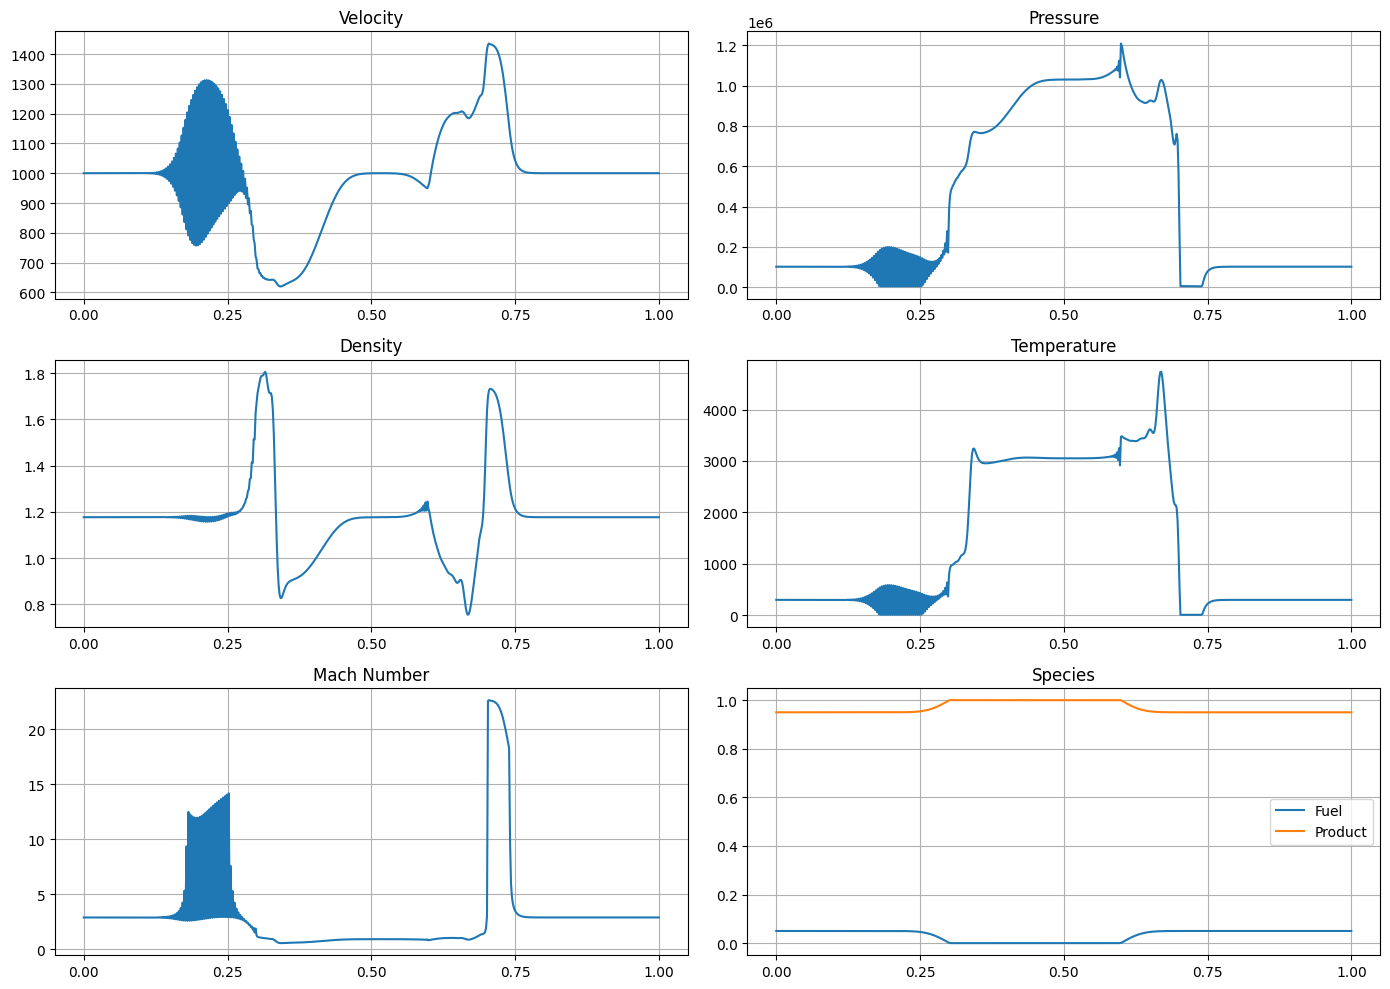

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Constants and physical parameters
gamma = 1.4
R = 287.0
nx = 600
x = np.linspace(0, 1.0, nx)
dx = x[1] - x[0]
A = 1 + 2.2 * (x - 0.5)**2  # Symmetric nozzle with narrow throat

# Initial conditions
T = np.ones(nx) * 300.0
P = np.ones(nx) * 101325.0
rho = P / (R * T)
u = np.ones(nx) * 1000.0
Y_F = np.ones(nx) * 0.05
Y_P = np.zeros(nx)
Et = rho * (R * T / (gamma - 1) + 0.5 * u**2)

# Combustion parameters
A_preexp = 5e6
Ea = 1.2e5
q_release = 3e7  # More energy release
reaction_zone = (x > 0.3) & (x < 0.6)

# MHD parameters
sigma = 50.0
B = np.ones(nx) * 0.3

# Time loop
t = 0.0
t_end = 0.002
CFL = 0.3
eps = 0.005

for step in range(300):
    a = np.sqrt(gamma * R * T)
    dt = CFL * dx / np.max(np.abs(u) + a)

    omega = A_preexp * Y_F * np.exp(-Ea / np.maximum(R * T, 1e-8)) * reaction_zone
    omega = np.clip(omega, 0, 1e6)
    q_dot = q_release * omega
    f_L = sigma * B**2 * u
    q_joule = sigma * u**2 * B**2

    F1 = rho * u
    F2 = rho * u**2 + P
    F3 = (Et + P) * u

    rho_p = rho - dt/dx * (np.roll(F1, -1) - F1)
    u_p = (rho * u - dt/dx * (np.roll(F2, -1) - F2) + dt * f_L) / np.maximum(rho_p, 1e-6)
    Et_p = Et - dt/dx * (np.roll(F3, -1) - F3) + dt * (q_dot + q_joule)

    T_p = (Et_p / np.maximum(rho_p, 1e-6) - 0.5 * u_p**2) * (gamma - 1) / R
    P_p = rho_p * R * np.maximum(T_p, 10.0)

    F1_p = rho_p * u_p
    F2_p = rho_p * u_p**2 + P_p
    F3_p = (Et_p + P_p) * u_p

    rho = 0.5 * (rho + rho_p - dt/dx * (F1_p - np.roll(F1_p, 1)))
    u = 0.5 * ((rho * u + rho_p * u_p - dt/dx * (F2_p - np.roll(F2_p, 1))) / np.maximum(rho, 1e-6))
    Et = 0.5 * (Et + Et_p - dt/dx * (F3_p - np.roll(F3_p, 1))) + dt * (q_dot + q_joule)

    T = (Et / rho - 0.5 * u**2) * (gamma - 1) / R
    T = np.maximum(T, 10.0)
    P = rho * R * T

    Y_F = np.clip(Y_F - dt * omega, 0, 1)
    Y_P = 1 - Y_F

    rho += eps * (np.roll(rho, -1) - 2 * rho + np.roll(rho, 1))
    Et += eps * (np.roll(Et, -1) - 2 * Et + np.roll(Et, 1))
    Y_F = 0.5 * (np.roll(Y_F, 1) + np.roll(Y_F, -1))
    u = 0.5 * (np.roll(u, 1) + np.roll(u, -1))
    t += dt

# Compute Mach number
M = u / np.sqrt(gamma * R * T)

# Plotting results
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs[0, 0].plot(x, u); axs[0, 0].set_title('Velocity')
axs[0, 1].plot(x, P); axs[0, 1].set_title('Pressure')
axs[1, 0].plot(x, rho); axs[1, 0].set_title('Density')
axs[1, 1].plot(x, T); axs[1, 1].set_title('Temperature')
axs[2, 0].plot(x, M); axs[2, 0].set_title('Mach Number')
axs[2, 1].plot(x, Y_F, label='Fuel'); axs[2, 1].plot(x, Y_P, label='Product'); axs[2, 1].legend(); axs[2, 1].set_title('Species')
for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.grid(True)
plt.tight_layout()
plt.savefig("/mnt/data/hypersonic_mach5_output.png")
plt.show()
